# Auditory Fear Conditioning in Autism-Related Rat Models: Behavioral Phenotyping of Arid1b, Grin2b, and Scn2a Strains

This tutorial shows how to access the data related to [EMBER:000199](https://dandi.emberarchive.org/dandiset/000199) using pynwb.

This dataset contains behavioral data from the auditory fear conditioning experiment, part of the [Rat Behavioural Phenotyping Pipeline Methodologies](https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/).


## Contents

1. [Setup and Data Access](#setup)
2. [Session and Subject Metadata](#metadata)
3. [Access Devices Metadata](#devices)
4. [Access Behavioral Videos](#behavior)
5. [Access Trials](#trials)



---

# 1. Setup and Data Access <a id="setup"></a>

## Import Required Libraries

In [1]:
# Core data manipulation and analysis
from pathlib import Path

import h5py

# Visualization
import matplotlib.pyplot as plt
import remfile
from dandi.dandiapi import DandiAPIClient, DandiInstance

# NWB and DANDI access
from pynwb import NWBHDF5IO

# Configure matplotlib
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Data Access Functions

In [2]:
def load_nwb_from_dandi(dandiset_id, subject_id, session_id):
    """
    Load NWB file from DANDI Archive via streaming.
    """
    pattern = f"sub-{subject_id}/sub-{subject_id}_ses-{session_id}*.nwb"
    dandi_instance = DandiInstance(
        "ember",
        "https://dandi.emberarchive.org",
        "https://api-dandi.emberarchive.org/api",
    )
    with DandiAPIClient(dandi_instance=dandi_instance) as client:
        client.dandi_authenticate()
        assets = client.get_dandiset(dandiset_id, "draft").get_assets_by_glob(
            pattern=pattern, order="path"
        )

        s3_urls = []
        for asset in assets:
            s3_url = asset.get_content_url(follow_redirects=1, strip_query=False)
            s3_urls.append(s3_url)

        if len(s3_urls) != 1:
            raise ValueError(f"Expected 1 file, found {len(s3_urls)} for pattern {pattern}")

        s3_url = s3_urls[0]

    file = remfile.File(s3_url)
    h5_file = h5py.File(file, "r")
    io = NWBHDF5IO(file=h5_file, load_namespaces=True)
    nwbfile = io.read()

    return nwbfile, io


def load_nwb_local(directory_path, subject_id, session_id):
    """
    Load NWB file from local directory.
    """
    directory_path = Path(directory_path)
    nwbfile_path = directory_path / f"sub-{subject_id}_ses-{session_id}.nwb"
    
    if not nwbfile_path.exists():
        raise FileNotFoundError(f"NWB file not found: {nwbfile_path}")
    
    io = NWBHDF5IO(path=nwbfile_path, load_namespaces=True)
    nwbfile = io.read()
    
    return nwbfile, io

In [3]:
# Load session data
dandiset_id = "000199"
session_id = "AFC-4-RecallD1"
subject_id = "1275-Grin2b(10)"

# Choose data source (DANDI streaming or local)
USE_DANDI = True  # Set to False to use local files

if USE_DANDI:
    nwbfile, io = load_nwb_from_dandi(dandiset_id, subject_id, session_id)
else:
    # Specify your local directory path
    local_directory = "YOUR_DIRECTORY_PATH"  # Replace with actual path
    nwbfile, io = load_nwb_local(local_directory, subject_id, session_id)

---

# 2. Session and Subject Metadata <a id="metadata"></a>

In [4]:
print("=== SESSION INFORMATION ===")
print(f"Experiment description:\n {nwbfile.experiment_description}")
print(f"Session description:\n {nwbfile.session_description}")
print(f"Session start time:\n {nwbfile.session_start_time}")

=== SESSION INFORMATION ===
Experiment description:
 This experiment is part of the Rat Behavioural Phenotyping Pipeline Methodologies https://sidb.org.uk/facilities/rat-behavioural-phenotyping-pipeline/.
As an initial effort to characterize the rat lines, these models are being behaviorally phenotyped at SIDB.
Rat models are phenotyped according to a rigorous pipeline that assesses behaviours relevant to autism with intellectual disability, such as social and motor skills, and learning and sensory processing.
Different cohorts of rats are run through different subsets of tasks to overcome potential order effects on behaviours and to limit the number of tasks each animal is put through.
This experiment investigated auditory fear conditioning in different rat models
(Arid1b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394518,
Grin2b: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=14394515,
Scn2a: https://rgd.mcw.edu/rgdweb/report/strain/main.html?id=25394530).
The exp

In [5]:
print("=== SUBJECT INFORMATION ===")
print(f"ID: {nwbfile.subject.subject_id}")
print(f"Age: {nwbfile.subject.age}")
print(f"Species: {nwbfile.subject.species}")
print(f"Strain: {nwbfile.subject.strain}")
print(f"Genotype: {nwbfile.subject.genotype}")
print(f"Sex: {nwbfile.subject.sex}")

=== SUBJECT INFORMATION ===
ID: 1275_Grin2b(10)
Age: None
Species: Rattus norvegicus
Strain: Grin2b
Genotype: HET
Sex: M


---

# 3. Access Devices Metadata <a id="devices"></a>

This section demonstrates how to access the [Device](https://pynwb.readthedocs.io/en/stable/pynwb.device.html#module-pynwb.device) field in an NWB file.

The [Device](https://pynwb.readthedocs.io/en/stable/pynwb.device.html#module-pynwb.device) field can be accessed as `nwbfile.devices`.

In [6]:
nwbfile.devices["camera_device 0"]

camera_device 0 abc.CameraDevice at 0x1301747096720
Fields:
  camera_name: BehavioralCamera
  description: CCTV camera mounted on ceiling above arenas for behavioral recording
  lens: Carl Zeiss lens with 20-step autofocus
  meters_per_pixel: 0.0004
  model: C920

In [7]:
nwbfile.devices["ChamberA"] # ChamberB

ChamberA pynwb.device.Device at 0x1301747592080
Fields:
  description: Coulbourn Fear conditioning chamber - Context A
Smooth plastic flooring, curved black/white striped plastic mat on walls,
black/white tiles, mint toothpaste odor cue

  manufacturer: Coulbourn, Harvard Apparatus

In [8]:
nwbfile.devices["SoundAttenuatingChamber"]

SoundAttenuatingChamber pynwb.device.Device at 0x1301747498960
Fields:
  description: Chamber housing the fear conditioning chambers for sound isolation
  manufacturer: Coulbourn, Harvard Apparatus

---

# 4. Access Behavioral Video <a id="behavior"></a>

The behavioral video is stored as an external `ImageSeries` in the NWB file.

In [9]:
video = nwbfile.acquisition["BehavioralVideo"]
video

Data type,uint8
Shape,"(0, 0, 0)"
Array size,0.00 bytes
Chunk shape,None
Compression,None
Compression opts,None
Uncompressed size (bytes),0
Compressed size (bytes),0
Compression ratio,undefined
Data type,float64
Shape,"(7414,)"


The video filepath:

In [10]:
video.external_file[0]

'sub-1275-Grin2b(10)_ses-AFC-4-RecallD1_image\\11fd0991-9550-4ede-a252-9f738f151a95_external_file_0.avi'

The metadata of the device used to record the behavioral video:


In [11]:
video.device

camera_device 0 abc.CameraDevice at 0x1301747096720
Fields:
  camera_name: BehavioralCamera
  description: CCTV camera mounted on ceiling above arenas for behavioral recording
  lens: Carl Zeiss lens with 20-step autofocus
  meters_per_pixel: 0.0004
  model: C920

---

# 5. Access Trials <a id="trials"></a>

The `nwbfile.trials` contains periods of freezing behavior, as detected and scored by the FreezeFrame 5 software.  
Each row in the table corresponds to a single freezing event, with columns for the start and stop times (relative to session start), and additional columns such as duration or manual scoring.

You can convert the trials table to a `pandas.DataFrame` for easier exploration:


In [12]:
nwbfile.intervals

{'epochs': epochs pynwb.epoch.TimeIntervals at 0x1301738829712
 Fields:
   colnames: ['start_time' 'stop_time' 'task_name' 'tags']
   columns: (
     start_time <class 'hdmf.common.table.VectorData'>,
     stop_time <class 'hdmf.common.table.VectorData'>,
     task_name <class 'hdmf.common.table.VectorData'>,
     tags_index <class 'hdmf.common.table.VectorIndex'>,
     tags <class 'hdmf.common.table.VectorData'>
   )
   description: experimental epochs
   id: id <class 'hdmf.common.table.ElementIdentifiers'>,
 'trials': trials pynwb.epoch.TimeIntervals at 0x1301744224080
 Fields:
   colnames: ['start_time' 'stop_time' 'percentage_of_time_spent_freezing' 'threshold'
  'bout_duration' 'protocol']
   columns: (
     start_time <class 'hdmf.common.table.VectorData'>,
     stop_time <class 'hdmf.common.table.VectorData'>,
     percentage_of_time_spent_freezing <class 'hdmf.common.table.VectorData'>,
     threshold <class 'hdmf.common.table.VectorData'>,
     bout_duration <class 'hdmf.comm

In [13]:
trials = nwbfile.trials.to_dataframe()
trials

,start_time,stop_time,percentage_of_time_spent_freezing,threshold,bout_duration,protocol
id,,,,,,
0,0.0,120.0,0.00,1.00,3.0,tone recall/extinction 5Khz tone
1,120.0,150.0,10.22,1.00,3.0,tone recall/extinction 5Khz tone
2,150.0,180.0,0.00,1.00,3.0,tone recall/extinction 5Khz tone
3,180.0,210.0,10.62,1.00,3.0,tone recall/extinction 5Khz tone
4,210.0,240.0,0.00,1.00,3.0,tone recall/extinction 5Khz tone
5,240.0,270.0,16.00,1.00,3.0,tone recall/extinction 5Khz tone
6,270.0,300.0,0.00,1.00,3.0,tone recall/extinction 5Khz tone
7,300.0,330.0,0.00,1.00,3.0,tone recall/extinction 5Khz tone
8,330.0,360.0,0.00,1.00,3.0,tone recall/extinction 5Khz tone


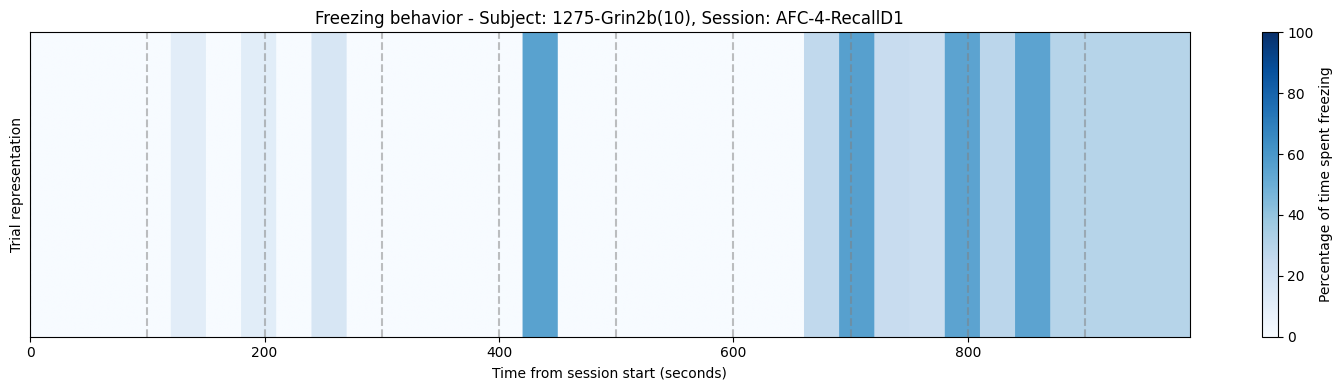

In [14]:
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np

# Calculate total experiment duration
experiment_duration = int(trials['stop_time'].max())

# Create an image array to represent the trials
image_width = experiment_duration
image_height = 100
image = np.zeros((image_height, image_width, 4))  # RGBA

# Define colormap for percentage of freezing (cool colors)
cmap = plt.cm.Blues

# Fill in the image with trial data
for _, row in trials.iterrows():
    start = int(round(row['start_time']))
    stop = int(round(row['stop_time']))
    width = stop - start
    
    # Get color based on percentage of time spent freezing
    freeze_pct = row['percentage_of_time_spent_freezing']
    color_intensity = freeze_pct / 100.0 if freeze_pct > 0 else 0
    color = cmap(color_intensity)
    
    # Fill the column with the appropriate color
    for x in range(start, stop):
        if x < image_width:
            image[:, x] = color

# Create a figure and display the image
fig, ax = plt.subplots(figsize=(15, 4))
ax.imshow(image, aspect='auto')

# Add color bar for reference
norm = mcolors.Normalize(vmin=0, vmax=100)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='Percentage of time spent freezing')

# Add labels and title
ax.set_title(f'Freezing behavior - Subject: {subject_id}, Session: {session_id}')
ax.set_xlabel('Time from session start (seconds)')
ax.set_ylabel('Trial representation')

# Remove y-axis ticks as they don't represent anything specific
ax.set_yticks([])

# Add some markers for reference every 100 seconds
for t in range(0, experiment_duration, 100):
    ax.axvline(x=t, color='gray', linestyle='--', alpha=0.5)
    
plt.tight_layout()
plt.show()